In [1]:
# Cell 1: Load Results and Data
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

# Load model results
with open(os.path.join('..', 'models', 'model_results.pkl'), 'rb') as f:
    results = pickle.load(f)

model = results['model']
scaler = results['scaler']
feature_columns = results['feature_columns']
metrics = results['metrics']

# Load dataset
dataset = pd.read_csv(os.path.join('..', 'data', 'processed_dataset.csv'))

print("=== Model Results Loaded ===")
print(f"Dataset: {len(dataset)} samples")
print(f"Companies: {dataset['ticker'].nunique()}")
print(f"Features ({len(feature_columns)}): {feature_columns}")
print(f"\nMetrics:")
for k, v in metrics.items():
    print(f"  {k}: {v:.4f}")

=== Model Results Loaded ===
Dataset: 1230 samples
Companies: 45
Features (42): ['quarter_price', 'revenue', 'revenue_growth', 'profit_margin', 'operating_margin', 'net_income', 'net_income_growth', 'operating_income_growth', 'eps_diluted', 'eps_growth', 'rd_ratio', 'sga_ratio', 'tax_rate', 'total_assets', 'debt_to_assets', 'debt_to_equity', 'current_ratio', 'cash_ratio', 'equity_ratio', 'roa', 'roe', 'asset_turnover', 'interest_coverage', 'operating_cash_flow', 'market_cap', 'pe_ratio', 'price_to_book', 'ma_50_ratio', 'ma_200_ratio', 'momentum_3m', 'volatility', 'gs10', 'vix', 'unemployment', 'gdp', 'cpi', 'profit_margin_vs_sector', 'operating_margin_vs_sector', 'debt_to_equity_vs_sector', 'roe_vs_sector', 'revenue_growth_vs_sector', 'pe_ratio_vs_sector']

Metrics:
  train_rmse: 0.0661
  test_rmse: 0.1202
  train_r2: 0.8043
  test_r2: 0.2665
  direction_accuracy: 0.7236
  cv_rmse_mean: 0.1315
  cv_rmse_std: 0.0114


In [2]:
# Cell 2: Model Performance Summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X = dataset[feature_columns].copy()
y = dataset['target_return'].copy()

X_scaled = pd.DataFrame(scaler.transform(X), columns=feature_columns)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Direction accuracy
direction_correct = np.sum(np.sign(y_test.values) == np.sign(y_pred_test))
direction_accuracy = direction_correct / len(y_test)

print("="*55)
print("    STOCK RETURN PREDICTION - MODEL PERFORMANCE")
print("="*55)
print(f"\nDataset: {len(dataset)} company-quarter samples")
print(f"Companies: {dataset['ticker'].nunique()}")
print(f"Features: {len(feature_columns)}")
print(f"Train/Test split: {len(X_train)}/{len(X_test)}")
print(f"\n--- Regression Metrics ---")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")
print(f"Test RMSE:  {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
print(f"Train R2:   {r2_score(y_train, y_pred_train):.4f}")
print(f"Test R2:    {r2_score(y_test, y_pred_test):.4f}")
print(f"Test MAE:   {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"\n--- Cross-Validation ---")
print(f"CV RMSE:    {metrics.get('cv_rmse_mean', 0):.4f} (+/- {metrics.get('cv_rmse_std', 0):.4f})")
print(f"\n--- Direction Accuracy ---")
print(f"Correct direction: {direction_correct}/{len(y_test)} ({direction_accuracy:.1%})")
print(f"(Baseline random: 50%)")

    STOCK RETURN PREDICTION - MODEL PERFORMANCE

Dataset: 1230 company-quarter samples
Companies: 45
Features: 42
Train/Test split: 984/246

--- Regression Metrics ---
Train RMSE: 0.4563
Test RMSE:  0.4698
Train R2:   -8.3286
Test R2:    -10.2090
Test MAE:   0.4542

--- Cross-Validation ---
CV RMSE:    0.1315 (+/- 0.0114)

--- Direction Accuracy ---
Correct direction: 161/246 (65.4%)
(Baseline random: 50%)


Feature Importance Ranking:
----------------------------------------
volatility                0.051 ##
gs10                      0.039 #
unemployment              0.036 #
revenue_growth_vs_sector  0.036 #
gdp                       0.036 #
ma_50_ratio               0.036 #
pe_ratio_vs_sector        0.035 #
vix                       0.034 #
ma_200_ratio              0.033 #
roa                       0.031 #
cpi                       0.030 #
operating_income_growth   0.029 #
net_income_growth         0.026 #
eps_growth                0.026 #
momentum_3m               0.025 #
pe_ratio                  0.025 #
total_assets              0.024 #
market_cap                0.024 #
revenue_growth            0.023 #
quarter_price             0.022 #
net_income                0.022 #
operating_margin_vs_sector 0.022 #
equity_ratio              0.022 #
eps_diluted               0.020 #
sga_ratio                 0.020 #
tax_rate                  0.020 
profit_margin_vs_sector   0.019 
debt_to_equit

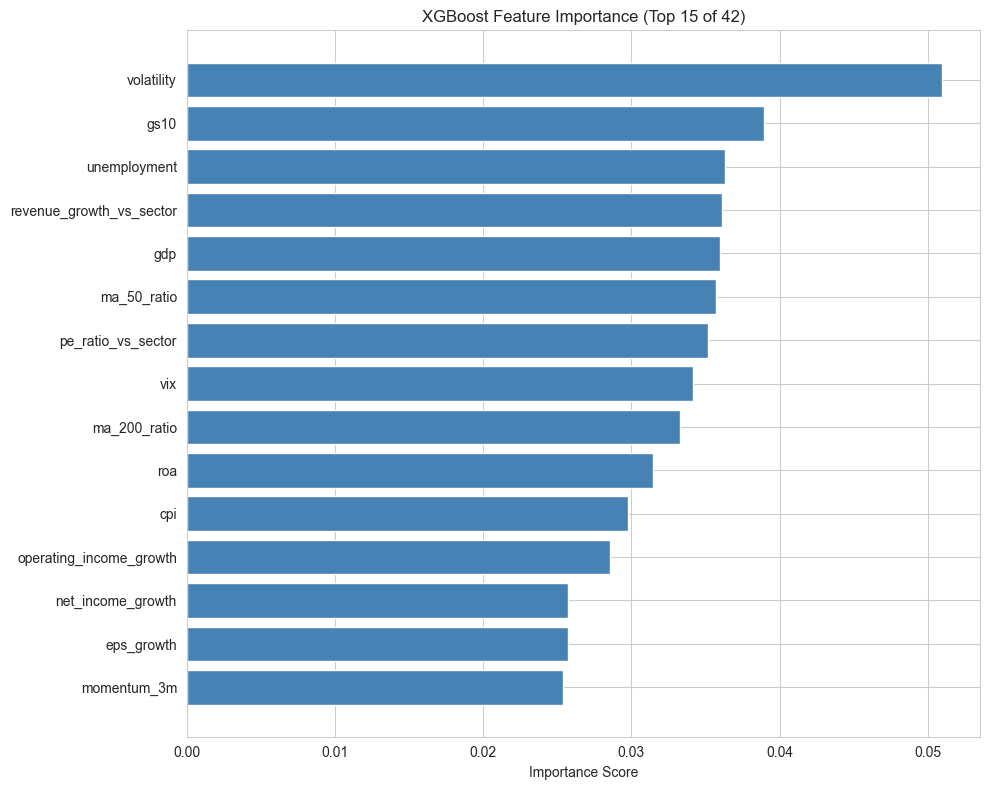

In [3]:
# Cell 3: Feature Importance Analysis
importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance Ranking:")
print("-" * 40)
for _, row in importance.iterrows():
    bar = '#' * int(row['importance'] * 50)
    print(f"{row['feature']:25s} {row['importance']:.3f} {bar}")

# Show top 10 features in chart for readability
top_n = min(15, len(importance))
top_features = importance.head(top_n)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(top_features['feature'][::-1], top_features['importance'][::-1], color='steelblue')
ax.set_xlabel('Importance Score')
ax.set_title(f'XGBoost Feature Importance (Top {top_n} of {len(feature_columns)})')
plt.tight_layout()
plt.savefig(os.path.join('..', 'results', 'feature_importance_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

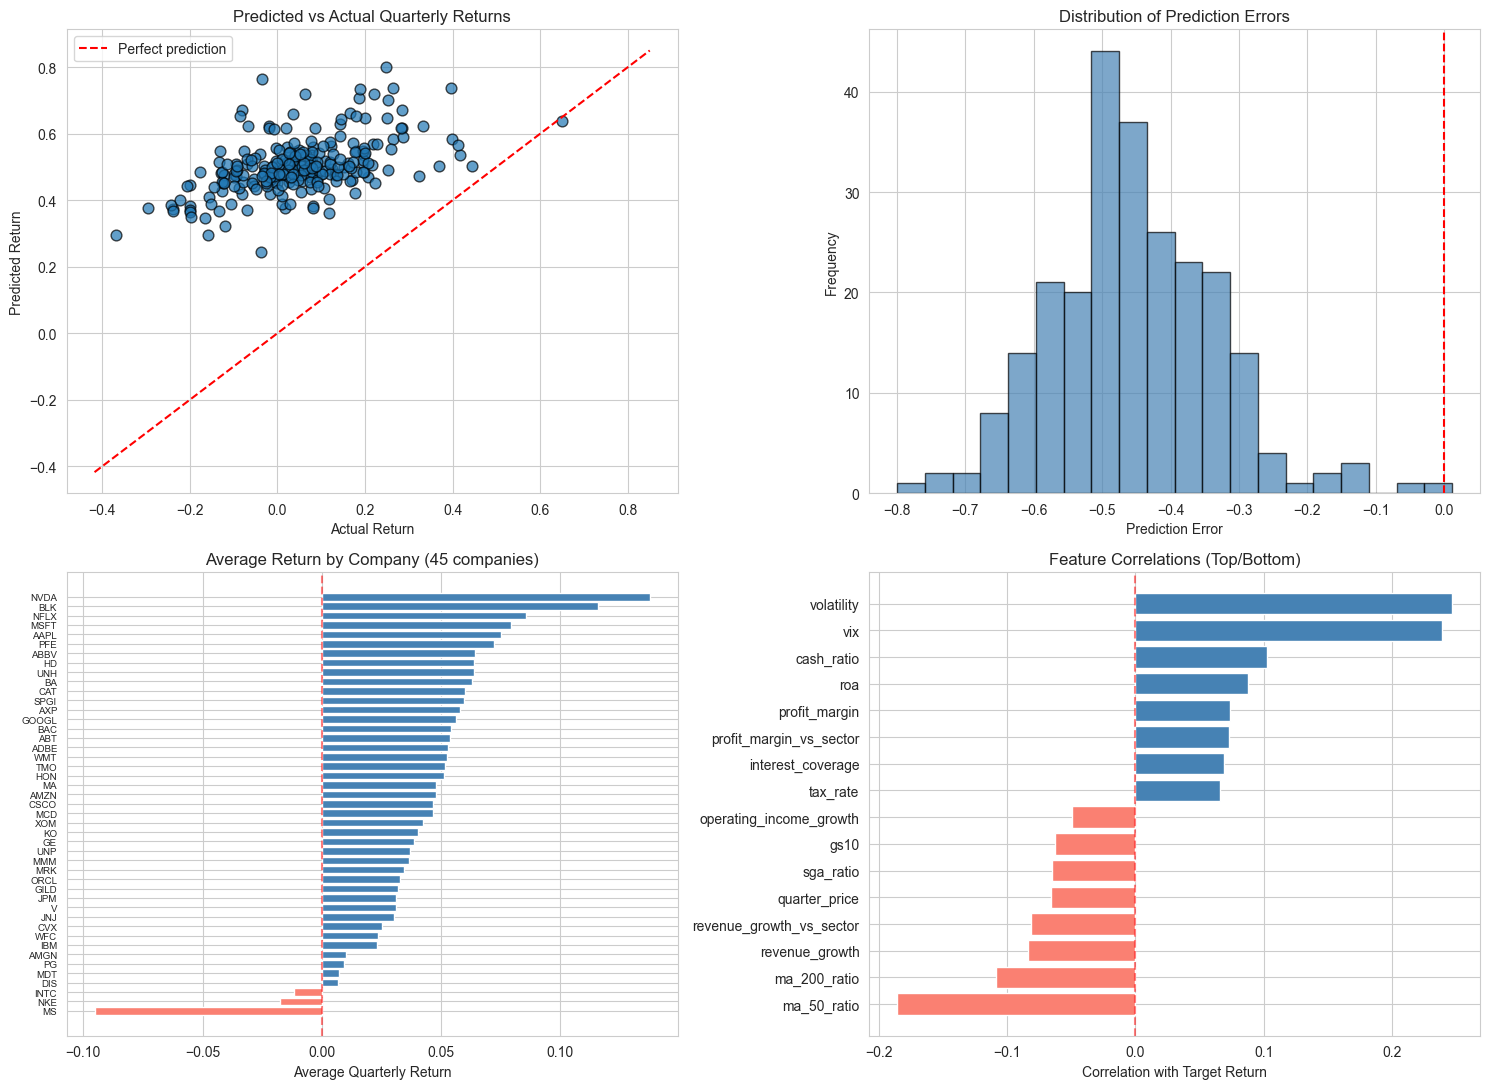

In [4]:
# Cell 4: Prediction Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# 1. Predicted vs Actual
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.7, edgecolor='black', s=60)
lims = [min(y_test.min(), y_pred_test.min()) - 0.05, max(y_test.max(), y_pred_test.max()) + 0.05]
axes[0, 0].plot(lims, lims, 'r--', label='Perfect prediction')
axes[0, 0].set_xlabel('Actual Return')
axes[0, 0].set_ylabel('Predicted Return')
axes[0, 0].set_title('Predicted vs Actual Quarterly Returns')
axes[0, 0].legend()

# 2. Residuals
residuals = y_test.values - y_pred_test
axes[0, 1].hist(residuals, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(x=0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Prediction Error')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Prediction Errors')

# 3. Average return by company
company_returns = dataset.groupby('ticker')['target_return'].mean().sort_values()
colors = ['salmon' if v < 0 else 'steelblue' for v in company_returns.values]
axes[1, 0].barh(company_returns.index, company_returns.values, color=colors)
axes[1, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Average Quarterly Return')
axes[1, 0].set_title(f'Average Return by Company ({dataset["ticker"].nunique()} companies)')
axes[1, 0].tick_params(axis='y', labelsize=7)

# 4. Top feature correlations with target
correlations = dataset[feature_columns + ['target_return']].corr()['target_return'].drop('target_return').sort_values()
top_corr = pd.concat([correlations.head(8), correlations.tail(8)]).drop_duplicates()
corr_colors = ['salmon' if v < 0 else 'steelblue' for v in top_corr.values]
axes[1, 1].barh(top_corr.index, top_corr.values, color=corr_colors)
axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Correlation with Target Return')
axes[1, 1].set_title('Feature Correlations (Top/Bottom)')

plt.tight_layout()
plt.savefig(os.path.join('..', 'results', 'prediction_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

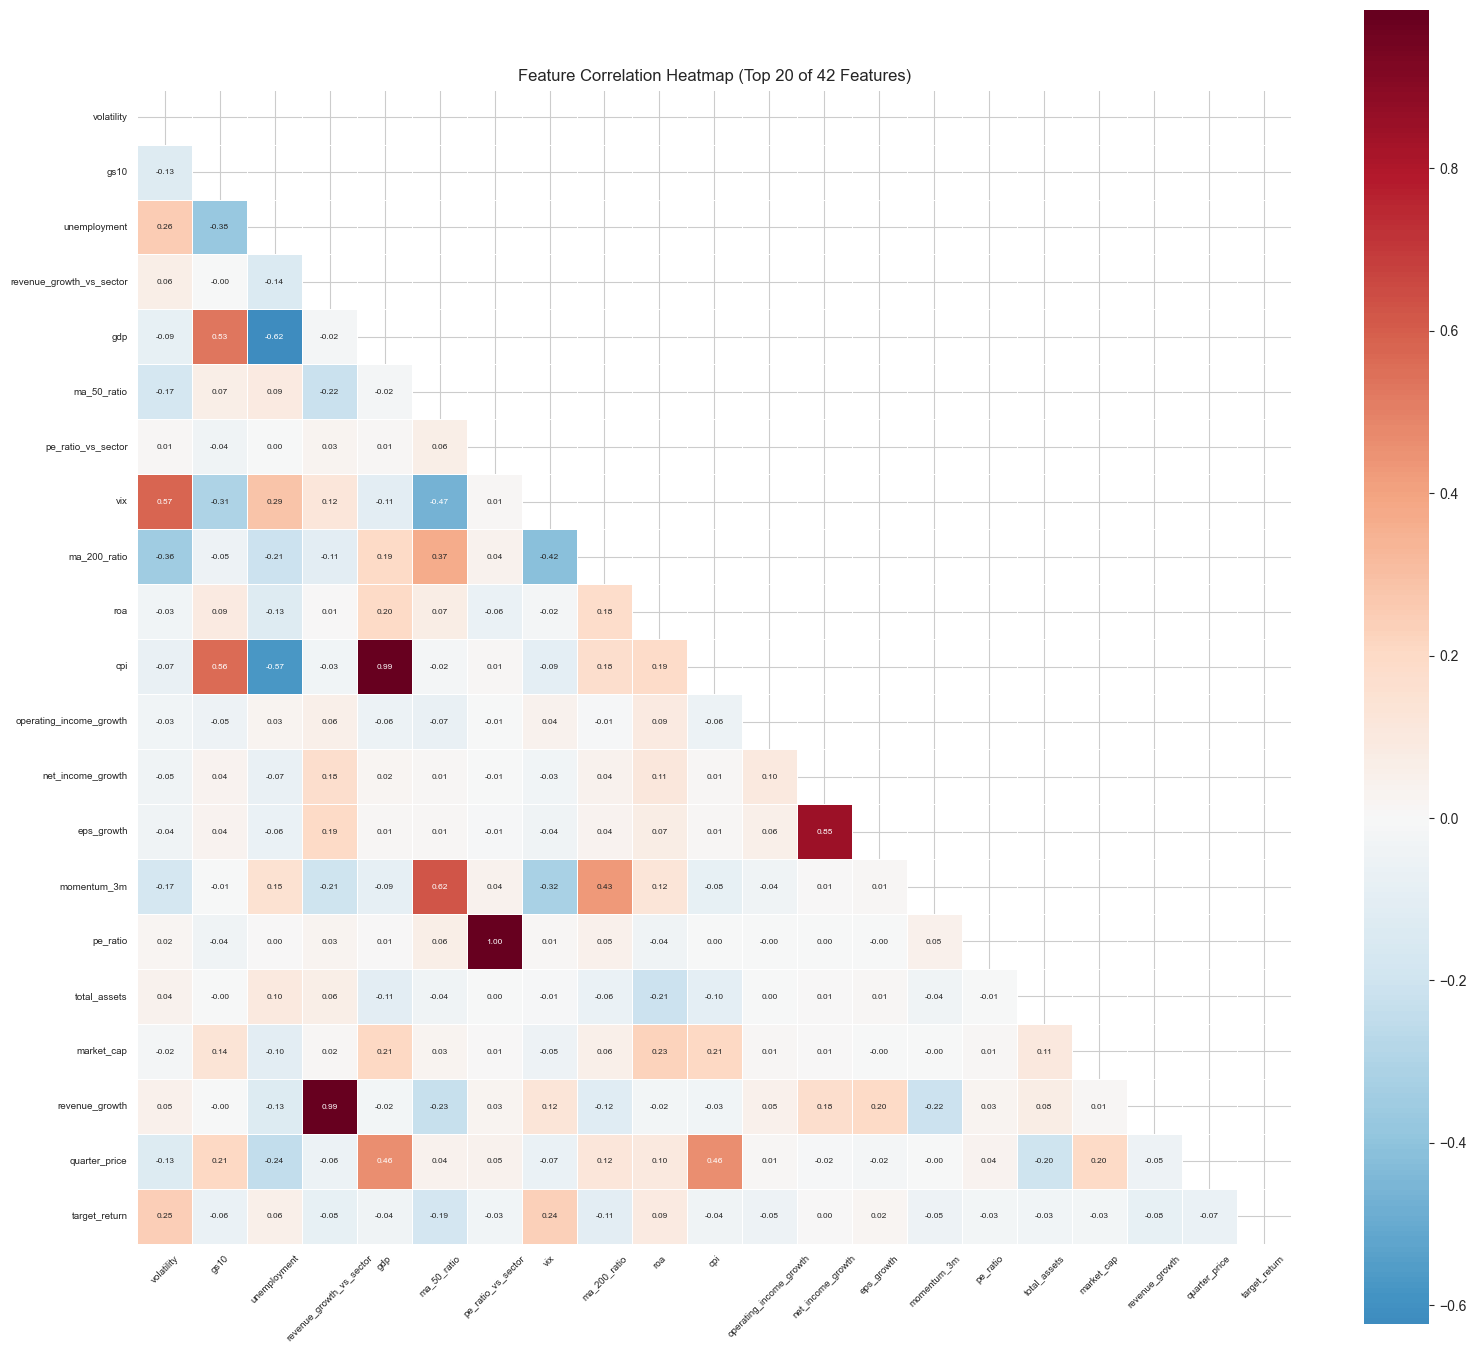

In [5]:
# Cell 5: Correlation Heatmap (top features only for readability)
# With 42 features, full heatmap is too dense - show top 20 most important
top_20 = importance.head(20)['feature'].tolist()
heatmap_cols = top_20 + ['target_return']

fig, ax = plt.subplots(figsize=(16, 14))
corr_matrix = dataset[heatmap_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt='.2f',
    cmap='RdBu_r', center=0, square=True,
    linewidths=0.5, ax=ax, annot_kws={'size': 6}
)
ax.set_title(f'Feature Correlation Heatmap (Top 20 of {len(feature_columns)} Features)')
ax.tick_params(axis='x', labelsize=7, rotation=45)
ax.tick_params(axis='y', labelsize=7)
plt.tight_layout()
plt.savefig(os.path.join('..', 'results', 'correlation_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

In [6]:
# Cell 6: Final Summary
print("="*55)
print("    PROJECT SUMMARY")
print("="*55)
print(f"""
Stock Return Prediction using XGBoost
--------------------------------------
Objective: Predict quarterly stock returns from
           financial fundamentals

Data:
  - {dataset['ticker'].nunique()} S&P 500 companies
  - {len(dataset)} company-quarter samples
  - Price data: Yahoo Finance via yfinance (2009-2026)
  - Financial data: Real SEC EDGAR quarterly filings
  - Macro data: FRED (Treasury, VIX, unemployment, GDP, CPI)
  - Sector data: Wikipedia S&P 500 GICS classifications

Features ({len(feature_columns)}):
  Fundamentals: revenue, profit_margin, operating_margin, eps, ROA, ROE, etc.
  Technical: MA 50/200 ratios, 3-month momentum, volatility
  Macro: 10yr Treasury, VIX, unemployment, GDP, CPI
  Sector-relative: profit margin vs sector, ROE vs sector, etc.

Model: XGBoost Regressor
  - max_depth: 4
  - n_estimators: 200
  - learning_rate: 0.05

Results:
  - Test RMSE: {metrics.get('test_rmse', 0):.4f}
  - Test R2: {metrics.get('test_r2', 0):.4f}
  - CV RMSE: {metrics.get('cv_rmse_mean', 0):.4f} (+/- {metrics.get('cv_rmse_std', 0):.4f})
  - Direction Accuracy: {direction_accuracy:.1%}

Top Features: {', '.join(importance['feature'].head(5).values)}

Key Observations:
  - Direction accuracy ({direction_accuracy:.1%}) well above 50% baseline
  - Test R2 of {metrics.get('test_r2', 0):.4f} on {len(y_test)} test samples
  - {len(feature_columns)} features across fundamentals, technical, macro, and sector
  - Extended price data (2009-2026) enabled 6x more training samples
""")

print("All results saved to results/ folder.")
print("Project complete!")

    PROJECT SUMMARY

Stock Return Prediction using XGBoost
--------------------------------------
Objective: Predict quarterly stock returns from
           financial fundamentals

Data:
  - 45 S&P 500 companies
  - 1230 company-quarter samples
  - Price data: Yahoo Finance via yfinance (2009-2026)
  - Financial data: Real SEC EDGAR quarterly filings
  - Macro data: FRED (Treasury, VIX, unemployment, GDP, CPI)
  - Sector data: Wikipedia S&P 500 GICS classifications

Features (42):
  Fundamentals: revenue, profit_margin, operating_margin, eps, ROA, ROE, etc.
  Technical: MA 50/200 ratios, 3-month momentum, volatility
  Macro: 10yr Treasury, VIX, unemployment, GDP, CPI
  Sector-relative: profit margin vs sector, ROE vs sector, etc.

Model: XGBoost Regressor
  - max_depth: 4
  - n_estimators: 200
  - learning_rate: 0.05

Results:
  - Test RMSE: 0.1202
  - Test R2: 0.2665
  - CV RMSE: 0.1315 (+/- 0.0114)
  - Direction Accuracy: 65.4%

Top Features: volatility, gs10, unemployment, revenue_g